## `inatall and imports'


In [ ]:
!pip install tensorflow # Install PyTorch with CUDA support
!pip install torch torchvision torchaudio
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv -y
!pip uninstall torch-geometric -y


In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")


PyTorch version: 2.5.0+cu121
CUDA available: True
CUDA version: 12.1


In [ ]:
# Install PyTorch Geometric dependencies with pre-built binaries
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

# Install torch-geometric
!pip install torch-geometric
!pip install torchinfo


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 19.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.3 MB/s eta 0:00:00


In [ ]:
import torch_geometric
from torch_geometric.data import Data
print("Torch Geometric version:", torch_geometric.__version__)


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Torch Geometric version: 2.6.1


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

## Data Processing

In [ ]:
weather_data = pd.read_csv('Datasets/complete_KNN_dataset_corrected.csv')
topo_features = pd.read_csv('Datasets/topological_features_365d_gpus.csv')
soil_data= pd.read_csv('Datasets/table_static_data_selected.csv')

yield_soil = pd.read_csv('Datasets/corn2001_2023_yield_data.csv')
yield_data = yield_soil[['Year', 'County', 'Value']]

# yield_data = yield_data[~((yield_data['Year'] == 2012) & (yield_data['Value'] < 90))]
yield_data = yield_data[~(yield_data['County'] =='OTHER (COMBINED) COUNTIES')]
yield_data= yield_data.rename(columns={'County': 'county'})
soil_data = soil_data.rename(columns={'NAME_U': 'county'})
soil_data = soil_data[['county', 'aws0_5', 'aws5_20',
       'aws20_50', 'aws0_20', 'soc0_20', 'soc0_30',
       'nccpi3corn', 'slope_r', 'elev_r',
        'W_avg_silt', 'W_avg_clay']]
yield_data = yield_data.rename(columns={'Year': 'year'})
weather_data = weather_data.rename(columns={'Date': 'date'})
topo_features = topo_features.rename(columns={'County': 'county'})

In [ ]:
yield_data = yield_data.rename(columns={'Value': 'value_old'})

In [ ]:
yield_data['Value'] = yield_data['value_old']+ (2023-yield_data['year'])*2.3373

In [ ]:
yield_data

,year,county,value_old,Value
0,2023,OTHER COUNTIES,202.5,202.5000
1,2023,BARTHOLOMEW,195.0,195.0000
2,2023,BOONE,207.2,207.2000
3,2023,CLINTON,234.4,234.4000
4,2023,DECATUR,221.9,221.9000
...,...,...,...,...
1980,2001,PUTNAM,157.8,209.2206
1981,2001,TIPPECANOE,157.5,208.9206
1982,2001,VERMILLION,160.6,212.0206
1983,2001,VIGO,148.7,200.1206


In [ ]:
len(yield_data.county.unique())

93

In [ ]:
# Assuming 'yield_data' is already loaded, let's find duplicate (county, year) pairs.

# Identify duplicate county-year pairs
duplicate_pairs = yield_data[yield_data.duplicated(subset=['county', 'year'], keep=False)]

# Display the duplicate pairs to the user
duplicate_pairs


,year,county,value_old,Value


In [ ]:
yield_data

,year,county,value_old,Value
0,2023,OTHER COUNTIES,202.5,202.5000
1,2023,BARTHOLOMEW,195.0,195.0000
2,2023,BOONE,207.2,207.2000
3,2023,CLINTON,234.4,234.4000
4,2023,DECATUR,221.9,221.9000
...,...,...,...,...
1980,2001,PUTNAM,157.8,209.2206
1981,2001,TIPPECANOE,157.5,208.9206
1982,2001,VERMILLION,160.6,212.0206
1983,2001,VIGO,148.7,200.1206


In [ ]:
import geopandas as gpd

# Load the county shapefile
counties = gpd.read_file('Datasets/Census_County_TIGER00_IN.shp')
counties = counties.rename(columns={'NAME_U': 'county'})


In [ ]:
import pandas as pd
'''
# Assuming df_yield is your yield dataframe
# And all_counties is a list of all county names in your region/state
all_counties = soil_data['county'].unique()  # Use the list of all county names from weather_data

# Assuming 'Year' and 'county' are the columns that list the year and county names in df_yield
# Iterate over each unique year in the yield dataset
years = yield_data['year'].unique()

new_rows = []

for year in years:
    # Step 1: Filter data for the specific year
    year_data = yield_data[yield_data['year'] == year]

    # Identify counties already present for this specific year
    present_counties = year_data['county'].unique().tolist()

    # Step 2: Identify the missing counties for this specific year
    missing_counties = [county for county in all_counties if county not in present_counties]

    # Step 3: Extract the "Other counties" data from the year-specific dataframe
    # Handle different variations of the "Other counties" labels
    other_county_data = year_data[
        year_data['county'].str.contains(r'OTHER.*COUNTIES', case=False, na=False)
    ]

    # Ensure there is "Other counties" data for this year
    if other_county_data.empty:
        print(f"No 'Other counties' row found for year {year}.")
    else:
        # Step 4: Create new rows for the missing counties for this year
        for _, row in other_county_data.iterrows():
            for missing_county in missing_counties:
                new_row = row.copy()
                new_row['county'] = missing_county
                new_rows.append(new_row)

# Step 5: Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Step 6: Append new rows to the original yield_data
yield_data_expanded = pd.concat([yield_data, new_rows_df], ignore_index=True)

# Step 7: Reset the index if needed
yield_data_expanded.reset_index(drop=True, inplace=True)

# Print to confirm changes (optional)
yield_data_expanded
'''


'\n# Assuming df_yield is your yield dataframe\n# And all_counties is a list of all county names in your region/state\nall_counties = soil_data[\'county\'].unique()  # Use the list of all county names from weather_data\n\n# Assuming \'Year\' and \'county\' are the columns that list the year and county names in df_yield\n# Iterate over each unique year in the yield dataset\nyears = yield_data[\'year\'].unique()\n\nnew_rows = []\n\nfor year in years:\n    # Step 1: Filter data for the specific year\n    year_data = yield_data[yield_data[\'year\'] == year]\n\n    # Identify counties already present for this specific year\n    present_counties = year_data[\'county\'].unique().tolist()\n\n    # Step 2: Identify the missing counties for this specific year\n    missing_counties = [county for county in all_counties if county not in present_counties]\n\n    # Step 3: Extract the "Other counties" data from the year-specific dataframe\n    # Handle different variations of the "Other counties" lab

In [ ]:
valid_counties = set(yield_data['county']).intersection(
    set(soil_data['county']),
    set(weather_data['county']),
    set(topo_features['county']),
    set(weather_data['county'])
)

len(valid_counties)

80

In [ ]:
# Get the unique counties from weather_data
# valid_counties = weather_data['county'].unique()

# Filter soil_data to include only counties present in weather_data
soil_data_filtered = soil_data[soil_data['county'].isin(valid_counties)]
topo_features_filtered = topo_features[topo_features['county'].isin(valid_counties)]
# Filter yield_data to include only counties present in weather_data
yield_data_filtered = yield_data[yield_data['county'].isin(valid_counties)]
weather_data_filtered = weather_data[weather_data['county'].isin(valid_counties)]
# Now you have filtered versions of both soil_data and yield_data that contain only relevant counties
print(f"Filtered soil_data contains {len(soil_data_filtered)} rows")
print(f"Filtered yield_data contains {len(yield_data_filtered)} rows")
print(f"Filtered weather_data contains {len(weather_data_filtered)} rows")
print(f"Filtered topo_features contains {len(topo_features_filtered)} rows")

Filtered soil_data contains 80 rows
Filtered yield_data contains 1700 rows
Filtered weather_data contains 529693 rows
Filtered topo_features contains 1441 rows


In [ ]:
import pandas as pd

# Assuming weather_data is already loaded
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])  # Ensure 'Date' column is in datetime format
weather_data_filtered['year'] = weather_data_filtered['date'].dt.year          # Extract year
weather_data_filtered['month'] = weather_data_filtered['date'].dt.month        # Extract month

# Filter weather data for April to August
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])
weather_data_filtered = weather_data_filtered[(weather_data_filtered['date'].dt.month >= 4) & (weather_data_filtered['date'].dt.month <= 8)]

# Check if any data remains after filtering
if weather_data_filtered.empty:
    print("Warning: No data found for the April–August period.")
else:
    print(f"Data retained for April–August: {len(weather_data_filtered)} rows")



<ipython-input-17-40795f34f49f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])  # Ensure 'Date' column is in datetime format
<ipython-input-17-40795f34f49f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['year'] = weather_data_filtered['date'].dt.year          # Extract year
<ipython-input-17-40795f34f49f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Data retained for April–August: 221916 rows


<ipython-input-17-40795f34f49f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])


In [ ]:
# Get the unique counties from each dataset
weather_counties = set(weather_data_filtered['county'].unique())
soil_counties = set(soil_data_filtered['county'].unique())  # Use the filtered version
yield_counties = set(yield_data_filtered['county'].unique())  # Use the filtered version
topo_features_counties = set(topo_features_filtered['county'].unique())
# Check for differences
counties_in_weather_not_in_soil = weather_counties - soil_counties
counties_in_soil_not_in_weather = soil_counties - weather_counties

counties_in_weather_not_in_yield = weather_counties - yield_counties
counties_in_yield_not_in_weather = yield_counties - weather_counties

counties_in_weather_not_in_topo = weather_counties - topo_features_counties
counties_in_topo_not_in_weather = topo_features_counties - weather_counties

counties_in_yield_not_in_topo = yield_counties - topo_features_counties
counties_in_topo_not_in_yield = topo_features_counties - yield_counties

# Print the results
print(f"Counties in weather data but not in soil data: {counties_in_weather_not_in_soil}")
print(f"Counties in soil data but not in weather data: {counties_in_soil_not_in_weather}")

print(f"Counties in weather data but not in yield data: {counties_in_weather_not_in_yield}")
print(f"Counties in yield data but not in weather data: {counties_in_yield_not_in_weather}")

print(f"Counties in weather data but not in topo features: {counties_in_weather_not_in_topo}")
print(f"Counties in topo features but not in weather data: {counties_in_topo_not_in_weather}")

print(f"Counties in yield data but not in topo features: {counties_in_yield_not_in_topo}")
print(f"Counties in topo features but not in yield data: {counties_in_topo_not_in_yield}")



Counties in weather data but not in soil data: set()
Counties in soil data but not in weather data: set()
Counties in weather data but not in yield data: set()
Counties in yield data but not in weather data: set()
Counties in weather data but not in topo features: set()
Counties in topo features but not in weather data: set()
Counties in yield data but not in topo features: set()
Counties in topo features but not in yield data: set()


In [ ]:
# Check common counties and years
weather_data_filtered['county'] = weather_data_filtered['county'].str.strip()  # clean up names if needed
topo_features_filtered['county'] = topo_features_filtered['county'].str.strip()
yield_data_filtered['county'] = yield_data_filtered['county'].str.strip()
soil_data_filtered['county'] = soil_data_filtered['county'].str.strip()

# Check if all counties are present in each dataset
print(set(weather_data_filtered['county']).intersection(set(topo_features['county'])))
print(set(weather_data_filtered['county']).intersection(set(yield_data['county'])))
print(set(weather_data_filtered['county']).intersection(set(soil_data['county'])))


{'STARKE', 'ALLEN', 'HENRY', 'NOBLE', 'WELLS', 'FULTON', 'DEARBORN', 'JOHNSON', 'JASPER', 'SPENCER', 'PARKE', 'JAY', 'ADAMS', 'HANCOCK', 'NEWTON', 'SCOTT', 'DUBOIS', 'BENTON', 'GIBSON', 'PIKE', 'STEUBEN', 'WHITE', 'VIGO', 'MARSHALL', 'LAWRENCE', 'MORGAN', 'RANDOLPH', 'PORTER', 'HAMILTON', 'MARTIN', 'CLAY', 'WHITLEY', 'KOSCIUSKO', 'LAKE', 'UNION', 'MONTGOMERY', 'LAGRANGE', 'CARROLL', 'SWITZERLAND', 'WABASH', 'BLACKFORD', 'WASHINGTON', 'HUNTINGTON', 'MADISON', 'PUTNAM', 'CLINTON', 'VANDERBURGH', 'ORANGE', 'CRAWFORD', 'KNOX', 'JENNINGS', 'FRANKLIN', 'PULASKI', 'JACKSON', 'DECATUR', 'RUSH', 'TIPTON', 'GRANT', 'VERMILLION', 'BARTHOLOMEW', 'JEFFERSON', 'TIPPECANOE', 'WARRICK', 'RIPLEY', 'HOWARD', 'FOUNTAIN', 'ELKHART', 'WAYNE', 'CASS', 'LA PORTE', 'DAVIESS', 'DELAWARE', 'POSEY', 'MARION', 'OWEN', 'MONROE', 'SULLIVAN', 'BOONE', 'PERRY', 'SHELBY'}
{'STARKE', 'ALLEN', 'HENRY', 'NOBLE', 'WELLS', 'FULTON', 'DEARBORN', 'JOHNSON', 'JASPER', 'SPENCER', 'PARKE', 'JAY', 'ADAMS', 'HANCOCK', 'NEWTON', '

<ipython-input-19-34f1297e1bdc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topo_features_filtered['county'] = topo_features_filtered['county'].str.strip()
<ipython-input-19-34f1297e1bdc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yield_data_filtered['county'] = yield_data_filtered['county'].str.strip()
<ipython-input-19-34f1297e1bdc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
weather_data_filtered

,date,county,mergedmax_temp,mergedmean_temp,mergedmin_temp,merged_precip,gdd,year,month
90,2001-04-01,ADAMS,48.0,41.0,34.0,0.190000,0.0,2001,4
91,2001-04-02,ADAMS,59.0,43.5,28.0,0.000000,0.0,2001,4
92,2001-04-03,ADAMS,54.0,47.0,40.0,0.000000,0.0,2001,4
93,2001-04-04,ADAMS,59.0,45.5,32.0,0.000000,0.0,2001,4
94,2001-04-05,ADAMS,73.0,53.0,33.0,0.000000,3.0,2001,4
...,...,...,...,...,...,...,...,...,...
535044,2023-08-27,WHITLEY,75.0,64.0,53.0,0.000000,14.0,2023,8
535045,2023-08-28,WHITLEY,76.0,63.5,51.0,0.000000,13.5,2023,8
535046,2023-08-29,WHITLEY,80.0,65.5,51.0,0.020000,15.5,2023,8
535047,2023-08-30,WHITLEY,71.0,59.5,48.0,0.071667,9.5,2023,8


In [ ]:
# Ensure weather_features columns are present and apply MinMaxScaler only if data exists
weather_features = ['mergedmax_temp', 'mergedmean_temp', 'mergedmin_temp', 'merged_precip', 'gdd']
missing_features = [feature for feature in weather_features if feature not in weather_data.columns]
if missing_features:
    print(f"Missing weather features: {missing_features}")
else:
    scaler = MinMaxScaler()
    weather_data[weather_features] = scaler.fit_transform(weather_data[weather_features])
    print("Weather data scaled successfully.")
#copy this later

Weather data scaled successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Ensure consistent casing in county names
for df in [yield_data_filtered, topo_features_filtered, weather_data_filtered, soil_data_filtered]:
    df['county'] = df['county'].str.upper()

# Identify common county-year pairs across yield, topo, and weather datasets
common_pairs = set(yield_data_filtered[['county', 'year']].apply(tuple, axis=1)) \
               & set(topo_features_filtered[['county', 'year']].apply(tuple, axis=1)) \
               & set(weather_data_filtered[['county', 'year']].apply(tuple, axis=1))

# Filter each dataset based on common county-year pairs
yield_data_filtered = yield_data_filtered[yield_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
topo_features_filtered = topo_features_filtered[topo_features_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
weather_data_filtered = weather_data_filtered[weather_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
soil_data_filtered = soil_data_filtered[soil_data_filtered['county'].isin(yield_data_filtered['county'].unique())]  # Soil by county only

# Filter weather data to only include April-August entries
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])
weather_data_filtered = weather_data_filtered[(weather_data_filtered['date'].dt.month >= 4) &
                                              (weather_data_filtered['date'].dt.month <= 8)]

# Scale features
scaler_weather = MinMaxScaler()
scaler_topo = MinMaxScaler()
scaler_soil = MinMaxScaler()

# Define feature columns
weather_features = ['mergedmax_temp', 'mergedmean_temp', 'mergedmin_temp', 'merged_precip', 'gdd']
topo_features_cols = topo_features_filtered.columns[2:]  # All columns except county, year
soil_features = soil_data_filtered.columns[1:]  # All columns except county

# Apply scaling
weather_data_filtered[weather_features] = scaler_weather.fit_transform(weather_data_filtered[weather_features])
topo_features_filtered[topo_features_cols] = scaler_topo.fit_transform(topo_features_filtered[topo_features_cols])
soil_data_filtered[soil_features] = scaler_soil.fit_transform(soil_data_filtered[soil_features])

# Organize weather data into sequences for each county-year pair
weather_sequences = {}
for (county, year), group in weather_data_filtered.groupby(['county', 'year']):
    sequence = group[weather_features].values
    if len(sequence) == 153:  # Ensure the sequence length is consistent (153 days for April-August)
        weather_sequences[(county, year)] = sequence

# Convert topo and soil data into dictionary lookups
topo_features_dict = topo_features_filtered.set_index(['county', 'year']).to_dict(orient='index')
soil_data_dict = soil_data_filtered.set_index('county').to_dict(orient='index')

# Filter valid pairs to ensure no missing data
valid_pairs = [pair for pair in common_pairs if pair in weather_sequences]

# Flatten Weather Sequences
weather_flattened = np.array([weather_sequences[(county, year)].flatten() for county, year in valid_pairs])

# Prepare Final Dataset
X = np.hstack([
    weather_flattened,
    np.array([list(topo_features_dict[(county, year)].values()) for county, year in valid_pairs]),
    np.array([list(soil_data_dict[county].values()) for county, _ in valid_pairs])
])

# Targets
y = yield_data_filtered[yield_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(valid_pairs)]['Value'].values

# Dataset is now ready for XGBoost


<ipython-input-22-06a213e1a6cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['county'] = df['county'].str.upper()
<ipython-input-22-06a213e1a6cf>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])
<ipython-input-22-06a213e1a6cf>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

## SVR-RBF model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Split the data into train, validation, and test sets (80%, 10%, 10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Define the SVR model with RBF kernel
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the SVR model
svr_rbf.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred = svr_rbf.predict(X_val_scaled)

# Evaluate on validation set
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation RMSE: {val_rmse:.4f}')
print(f'Validation R²: {val_r2:.4f}')


Validation RMSE: 27.7899
Validation R²: -0.0379



Test Set Evaluation Metrics:
Mean Absolute Error (MAE): 19.7880
Mean Squared Error (MSE): 861.3381
Root Mean Squared Error (RMSE): 29.3486
Mean Absolute Percentage Error (MAPE): 13.60%
R-squared (R²): -0.0457


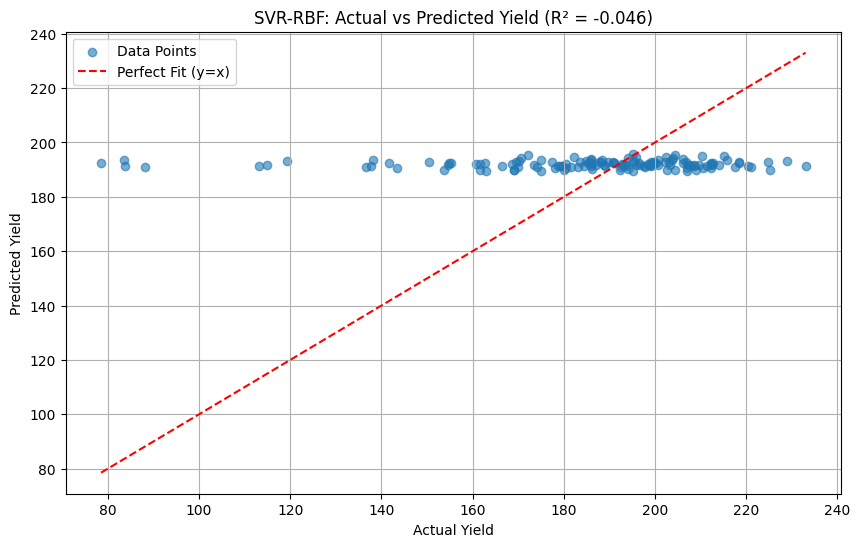

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test set
y_test_pred = svr_rbf.predict(X_test_scaled)

# Calculate evaluation metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r2 = r2_score(y_test, y_test_pred)

# Print all metrics
print("\nTest Set Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {test_mape:.2f}%")
print(f"R-squared (R²): {test_r2:.4f}")

# Plot Actual vs Predicted for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, label='Data Points', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit (y=x)')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'SVR-RBF: Actual vs Predicted Yield (R² = {test_r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'C': 100, 'epsilon': 0.5, 'gamma': 0.1}
Tuned Validation RMSE: 27.3287
Tuned Validation R²: -0.0038
Tuned Test RMSE: 28.8302
Tuned Test R²: -0.0090


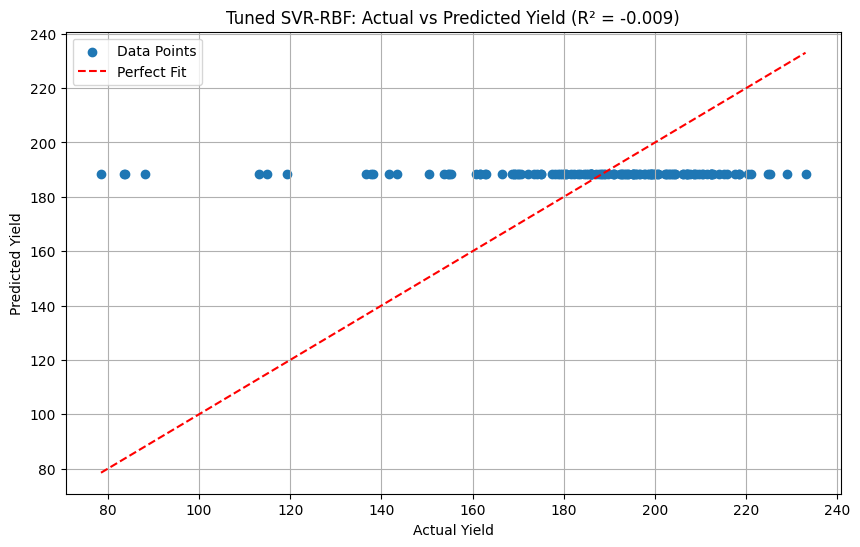

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error

# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

# Define the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize the SVR model
svr = SVR(kernel='rbf')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scorer, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the SVR model with the best parameters
best_svr = SVR(kernel='rbf', C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])
best_svr.fit(X_train_scaled, y_train)

# Evaluate the tuned model
y_val_pred = best_svr.predict(X_val_scaled)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Tuned Validation RMSE: {val_rmse:.4f}')
print(f'Tuned Validation R²: {val_r2:.4f}')

# Predict and evaluate on test set
y_test_pred = best_svr.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f'Tuned Test RMSE: {test_rmse:.4f}')
print(f'Tuned Test R²: {test_r2:.4f}')

# Plot Actual vs Predicted for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Tuned SVR-RBF: Actual vs Predicted Yield (R² = {test_r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


## XBOOST model

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (1293, 794), Test set size: (50, 794)


In [ ]:
from xgboost import XGBRegressor

# Initialize XGBoost model with GPU support
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.001,
    max_depth=50,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',  # Use GPU for histogram optimization
    device = 'cuda',  # Use GPU for prediction
    random_state=42
)

# Training loop with early stopping
min_val_rmse = float('inf')
best_iteration = 0

for iteration in range(1, 1001):
    xgb_model.n_estimators = iteration
    xgb_model.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = xgb_model.predict(X_test)

    # Compute validation RMSE
    val_rmse = np.sqrt(mean_squared_error(y_test, y_val_pred))

    print(f"Iteration {iteration}: Validation RMSE = {val_rmse:.4f}")

    # Early stopping logic
    if val_rmse < min_val_rmse:
        min_val_rmse = val_rmse
        best_iteration = iteration
    elif iteration - best_iteration >= 50:  # Stop if no improvement for 50 iterations
        print(f"Early stopping at iteration {iteration}")
        break

# Set the model to the best iteration
xgb_model.n_estimators = best_iteration


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:09:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Iteration 1: Validation RMSE = 32.9834
Iteration 2: Validation RMSE = 32.9858
Iteration 3: Validation RMSE = 32.9816
Iteration 4: Validation RMSE = 32.9838
Iteration 5: Validation RMSE = 32.9808
Iteration 6: Validation RMSE = 32.9751
Iteration 7: Validation RMSE = 32.9725
Iteration 8: Validation RMSE = 32.9729
Iteration 9: Validation RMSE = 32.9718
Iteration 10: Validation RMSE = 32.9748
Iteration 11: Validation RMSE = 32.9748
Iteration 12: Validation RMSE = 32.9771
Iteration 13: Validation RMSE = 32.9803
Iteration 14: Validation RMSE = 32.9790
Iteration 15: Validation RMSE = 32.9831
Iteration 16: Validation RMSE = 32.9860
Iteration 17: Validation RMSE = 32.9890
Iteration 18: Validation RMSE = 32.9895
Iteration 19: Validation RMSE = 32.9900
Iteration 20: Validation RMSE = 32.9898
Iteration 21: Validation RMSE = 32.9880
Iteration 22: Validation RMSE = 32.9878
Iteration 23: Validation RMSE = 32.9880
Iteration 24: Validation RMSE = 32.9880
Iteration 25: Validation RMSE = 32.9853
Iteration

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 300, 500]
}

# Initialize the model
xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda', random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)


In [ ]:
from xgboost import XGBRegressor

# Initialize XGBoost model with GPU support
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.01,
    max_depth=18,
    subsample=0.6,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization term
    reg_lambda=1.0,  # L2 regularization term
    tree_method='hist',  # Use GPU for histogram optimization
    device = 'cuda',  # Use GPU for prediction
    random_state=42
)

# Training loop with early stopping
min_val_rmse = float('inf')
best_iteration = 0

for iteration in range(1, 101):
    xgb_model.n_estimators = iteration
    xgb_model.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = xgb_model.predict(X_test)

    # Compute validation RMSE
    val_rmse = np.sqrt(mean_squared_error(y_test, y_val_pred))

    print(f"Iteration {iteration}: Validation RMSE = {val_rmse:.4f}")

    #Early stopping logic
    if val_rmse < min_val_rmse:
        min_val_rmse = val_rmse
        best_iteration = iteration
    elif iteration - best_iteration >= 10:  # Stop if no improvement for 50 iterations
        print(f"Early stopping at iteration {iteration}")
        break

# Set the model to the best iteration
xgb_model.n_estimators = best_iteration


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print all metrics
print("\nXGBoost Test Set Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%")
print(f"R-squared (R²): {r2_xgb:.4f}")

# Plot Predicted vs Actual for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit (y=x)')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'XGBoost Predicted vs. Actual Yield (R² = {r2_xgb:.4f})')
plt.legend()
plt.grid(True)
plt.show()

# Map predictions back to county-year for analysis
# Assuming `valid_pairs` contains county-year pairs in the correct order corresponding to the dataset
test_pairs = [valid_pairs[i] for i in range(len(X)) if (X[i] == X_test).all(axis=1).any()]  # Adjusted for county-year matching

# Create a DataFrame with predictions
results_df = pd.DataFrame({
    'County-Year': test_pairs[:len(y_test)],  # Ensure we only take as many as test predictions
    'Actual Yield': y_test,
    'Predicted Yield': y_pred_xgb
})

# Display the results DataFrame
print("\nXGBoost Test Predictions DataFrame:")
print(results_df)

# Optionally save results to CSV
# results_df.to_csv("xgboost_test_predictions.csv", index=False)


## SVR- single aproach

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Flatten weather data
weather_flattened = np.array([weather_sequences[(county, year)].flatten() for county, year in valid_pairs])

# 2. Combine with topo and soil features
X = np.hstack([
    weather_flattened,
    np.array([list(topo_features_dict[(county, year)].values()) for county, year in valid_pairs]),
    np.array([list(soil_data_dict[county].values()) for county, year in valid_pairs])
])

# 3. Target values (yield)
y = yield_data_filtered[yield_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(valid_pairs)]['Value'].values

# 4. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.svm import SVR

# Initialize SVR with RBF kernel
svr_model = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.2)

# Train the model
svr_model.fit(X_train, y_train)


SVR(C=10, epsilon=0.2, gamma=0.1)

Test RMSE: 28.6066
Test R2: -0.0434


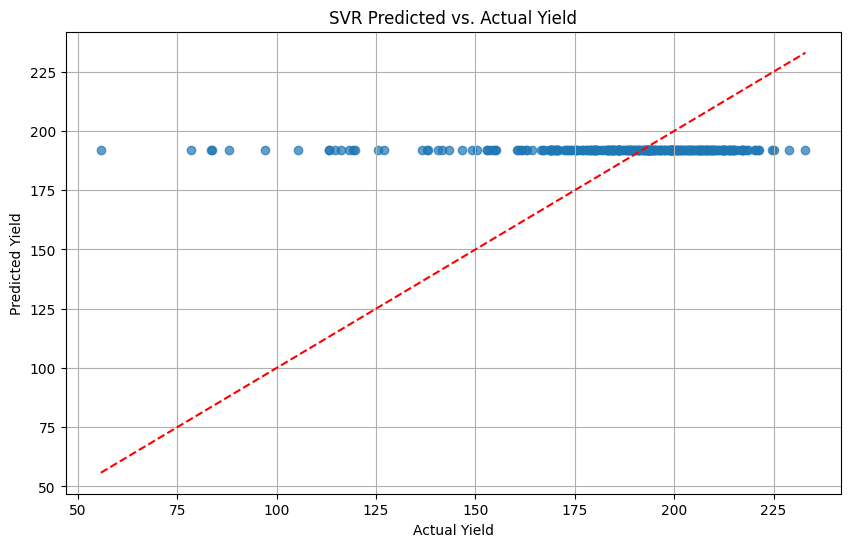

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
y_pred = svr_model.predict(X_test)

# Calculate RMSE and R2 score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2: {r2:.4f}")

# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('SVR Predicted vs. Actual Yield')
plt.grid(True)
plt.show()


## Combined- VAR-SVR model for temporal dependency capture

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR

# 1. Ensure consistent casing in county names
for df in [yield_data_filtered, topo_features_filtered, weather_data_filtered, soil_data_filtered]:
    df['county'] = df['county'].str.upper()

# 2. Identify common county-year pairs across datasets
common_pairs = set(yield_data_filtered[['county', 'year']].apply(tuple, axis=1)) & \
               set(topo_features_filtered[['county', 'year']].apply(tuple, axis=1)) & \
               set(weather_data_filtered[['county', 'year']].apply(tuple, axis=1))

# 3. Filter datasets to only include common pairs
yield_data_filtered = yield_data_filtered[yield_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
topo_features_filtered = topo_features_filtered[topo_features_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
weather_data_filtered = weather_data_filtered[weather_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
soil_data_filtered = soil_data_filtered[soil_data_filtered['county'].isin(yield_data_filtered['county'].unique())]

# 4. Filter weather data to April-August and scale features
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])
weather_data_filtered = weather_data_filtered[(weather_data_filtered['date'].dt.month >= 4) &
                                              (weather_data_filtered['date'].dt.month <= 8)]

scaler_weather = MinMaxScaler()
scaler_topo = MinMaxScaler()
scaler_soil = MinMaxScaler()

weather_features = ['mergedmax_temp', 'mergedmean_temp', 'mergedmin_temp', 'merged_precip', 'gdd']
topo_features_cols = topo_features_filtered.columns[2:]
soil_features = soil_data_filtered.columns[1:]

weather_data_filtered[weather_features] = scaler_weather.fit_transform(weather_data_filtered[weather_features])
topo_features_filtered[topo_features_cols] = scaler_topo.fit_transform(topo_features_filtered[topo_features_cols])
soil_data_filtered[soil_features] = scaler_soil.fit_transform(soil_data_filtered[soil_features])

# 5. Organize weather data into sequences for each county-year pair
weather_sequences = {}
for (county, year), group in weather_data_filtered.groupby(['county', 'year']):
    sequence = group[weather_features].values
    if len(sequence) == 153:  # Ensure the sequence length is consistent
        weather_sequences[(county, year)] = sequence

# 6. VAR model on weather data to extract residuals
residuals_dict = {}
valid_pairs = list(weather_sequences.keys())

for pair in valid_pairs:
    weather_seq = weather_sequences[pair]
    var_model = VAR(weather_seq)
    fitted_model = var_model.fit()
    residuals = fitted_model.resid.flatten()
    residuals_dict[pair] = residuals

# Convert residuals_dict to a list for matching valid_pairs
X_var_resid = np.array([residuals_dict[pair] for pair in valid_pairs])

# 7. Prepare topography and soil data
topo_features_list = np.array([list(topo_features_dict[(county, year)].values()) for county, year in valid_pairs])
soil_features_list = np.array([list(soil_data_dict[county].values()) for county, year in valid_pairs])

# 8. Combine all features
X_combined = np.hstack([X_var_resid, topo_features_list, soil_features_list])

# 9. Extract target yield values
y = yield_data_filtered[yield_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(valid_pairs)]['Value'].values


Test RMSE: 34.3791
Test R²: -0.1650
         County-Year  Actual Yield  Predicted Yield
0          OWEN-2012      149.0595       193.100707
1          KNOX-2001      105.5103       188.671241
2      HAMILTON-2018      168.5984       193.188142
3        HOWARD-2010      209.6357       191.212628
4         POSEY-2002      170.8968       192.968044
5        FULTON-2013      208.6238       191.938967
6       WHITLEY-2019      197.8206       208.836818
7        WABASH-2006      167.1833       189.967076
8        HOWARD-2023      213.9357       189.721809
9        MARTIN-2012      189.5849       191.615989
10     RANDOLPH-2022      192.3341       191.758544
11   MONTGOMERY-2012      209.7222       194.437653
12    BLACKFORD-2014      200.6373       199.635663
13       SHELBY-2015      170.1714       193.084017
14        POSEY-2004      182.8968       185.911743
15         VIGO-2003      161.5833       185.925230
16       ORANGE-2004      186.0595       187.429037
17      MADISON-2018      19

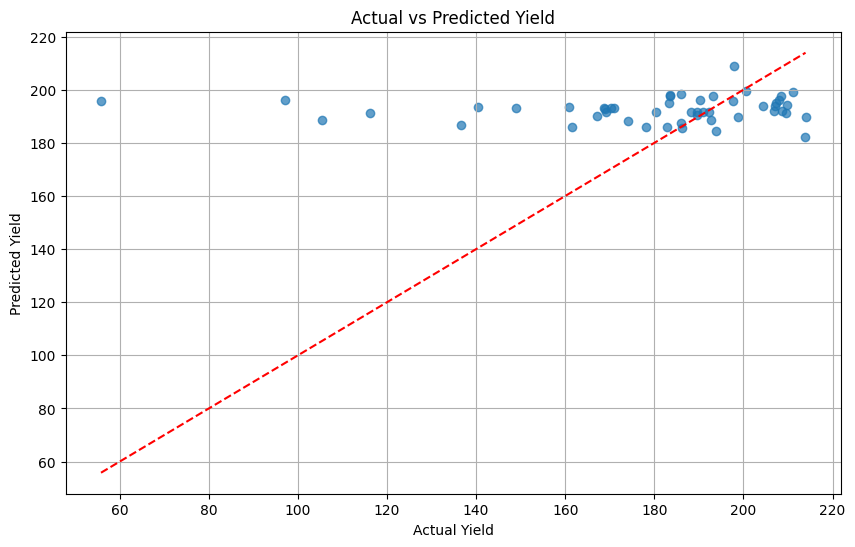

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=50, random_state=42)

# Split the county-year pairs in the same way
_, test_pairs = train_test_split(valid_pairs, test_size=50, random_state=42)

# Train the SVR model
svr_model = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1)
svr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

# Combine predictions with county-year pairs
test_results = pd.DataFrame({
    'County-Year': [f"{county}-{year}" for county, year in test_pairs],
    'Actual Yield': y_test,
    'Predicted Yield': y_pred
})

# Display the results
print(test_results)

# Save the results to a CSV file (optional)
test_results.to_csv('svr_test_results.csv', index=False)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'epsilon': [0.1, 0.2, 0.5, 1]
}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.7s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.7s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.6s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.5s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.5s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.5s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.5s
[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s
[CV] END .....................C=0.1, epsilon=0

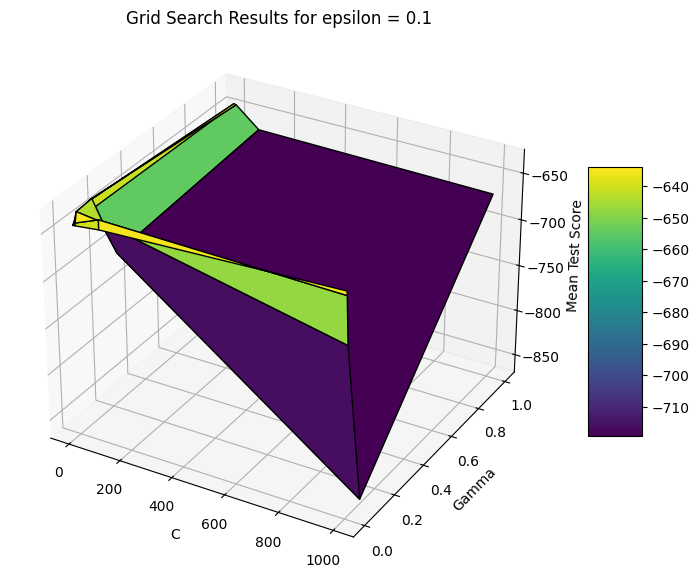

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract results from GridSearchCV
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

# Get unique values for each parameter
param_C = np.array(grid_search.param_grid['C'])
param_gamma = np.array(grid_search.param_grid['gamma'])
param_epsilon = np.array(grid_search.param_grid['epsilon'])

# Choose a specific epsilon value to visualize, e.g., first value
chosen_epsilon = param_epsilon[0]

# Filter results for the chosen epsilon
mask = results['param_epsilon'] == chosen_epsilon
filtered_scores = mean_test_scores[mask]

# Reshape filtered results to match C and gamma grid
scores_matrix = filtered_scores.reshape(len(param_C), len(param_gamma))

# Create meshgrid for C and gamma
C_grid, gamma_grid = np.meshgrid(param_C, param_gamma)

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(C_grid, gamma_grid, scores_matrix.T, cmap='viridis', edgecolor='k')

# Labels
ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Test Score')
ax.set_title(f'Grid Search Results for epsilon = {chosen_epsilon}')

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()
